# Community Detection Algorithm Evaluation (n=495)
### Aim:
Determine which community detection algorithm defines communities with the greatest semantic similarity to the gene of interest
<br>
### Output:
- Statistical analysis of community detection algorithms
- Box and whisker plot of community detection algorithm results
<br>

#### Description:
- Determine the data distribution and perform one tail ANOVA to identify if there are significant differences between the data distributions
- Perform a pair wise independent T-Test and determine which algorithms are significantly different to each other
- Plot results as a box and whisker plot with statistical annotations

In [1]:
# Import DepMap tools and packages
from DepMapTools.DataImport import SaveLoad
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations
import seaborn as sns
import os
import pandas as pd

In [2]:
# Instantiate SaveLoad class
sl = SaveLoad()

In [3]:
# Define directory path for figure
PRD = ".."
dir_name = 'Figures'
data_path = os.path.join(PRD, dir_name)
os.makedirs(data_path,
            exist_ok=True)

In [4]:
# Define file paths (n=495)
PRD2 = "."
k_path = os.path.join(PRD2,
                      'pickle_files/chronos_k_similarity_significant_495.pickle')
gn_path = os.path.join(PRD2,
                       'pickle_files/chronos_girvan_similarity_significant_495.pickle')
lo_path = os.path.join(PRD2,
                       'pickle_files/chronos_louvain_similarity_significant_495.pickle')
la_path = os.path.join(PRD2,
                       'pickle_files/chronos_label_similarity_significant_495.pickle')

In [5]:
# Load similarity results dictionaries
kclique = sl.load_dict_pickle(k_path)
girvan = sl.load_dict_pickle(gn_path)
louvain = sl.load_dict_pickle(lo_path)
label = sl.load_dict_pickle(la_path)

### STATISTICAL ANALYSIS

In [6]:
# Identify skew understand distribution
k_skew = stats.skew(list(kclique['gsea_analysis'].values()))
g_skew = stats.skew(list(girvan['gsea_analysis'].values()))
l_skew = stats.skew(list(louvain['gsea_analysis'].values()))
la_skew = stats.skew(list(label['gsea_analysis'].values()))
print(f'Data Skew\n\nK-CLqiue: {k_skew}\nGirvan-Newman: {g_skew}\nLouvain: {l_skew}\nLabel Propagation: {la_skew}')

Data Skew

K-CLqiue: 0.08500440824080131
Girvan-Newman: 0.10173119941915848
Louvain: 0.3891556922740227
Label Propagation: 0.27757241946047806


In [7]:
# Perform Kolmogorov-Smirnov test against normal distribution
k, pk = stats.kstest(list(kclique['gsea_analysis'].values()), 'norm')
g, pg = stats.kstest(list(girvan['gsea_analysis'].values()), 'norm')
l, pl = stats.kstest(list(louvain['gsea_analysis'].values()), 'norm')
la, pla = stats.kstest(list(label['gsea_analysis'].values()), 'norm')

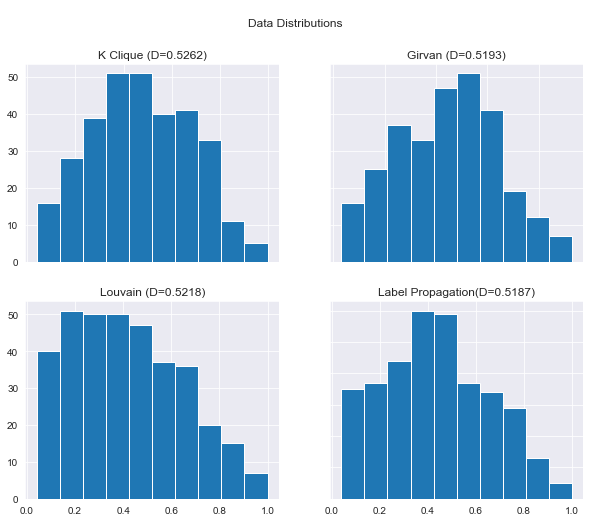

In [8]:
# Plot data distributions as histograms
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2, 2)
fig.suptitle('\nData Distributions\n')
fig.set_size_inches(10,8)
axs[0, 0].hist(list(kclique['gsea_analysis'].values()))
axs[0, 0].set_title(f'K Clique (D={k:.4f})')
axs[0, 1].hist(list(girvan['gsea_analysis'].values()))
axs[0, 1].set_title(f'Girvan (D={g:.4f})')
axs[1, 0].hist(list(louvain['gsea_analysis'].values()))
axs[1, 0].set_title(f'Louvain (D={l:.4f})')
axs[1, 1].hist(list(label['gsea_analysis'].values()))
axs[1, 1].set_title(f'Label Propagation(D={la:.4f})')
# Hide x labels
for ax in axs.flat:
    ax.label_outer()
plt.show()

In [9]:
# Perform one tail Anova to identify if there are any significant differences in the dataset
F, p = stats.f_oneway(list(kclique['gsea_analysis'].values()),
                      list(girvan['gsea_analysis'].values()),
                      list(louvain['gsea_analysis'].values()),
                      list(label['gsea_analysis'].values()))
if p < 0.01:
    print (f'P-value is significant (p={p:.4f})')
else:
    print (f'P-value not significant (p={p:.4f})')

P-value not significant (p=0.0142)


In [10]:
# Define dictionary for pairwise independent T-Test
dict_algs = {}
dict_algs['K Clique'] = list(kclique['gsea_analysis'].values())
dict_algs['Girvan'] = list(girvan['gsea_analysis'].values())
dict_algs['Louvain'] = list(louvain['gsea_analysis'].values())
dict_algs['Label'] = list(label['gsea_analysis'].values())

In [11]:
# Perform pairwise independent T-Tests
algorithms = list(dict_algs.keys())
df_list = []
for i, j in combinations(algorithms, 2):
    results = stats.ttest_ind(dict_algs[i],
                              dict_algs[j])
    df = pd.DataFrame({'Alg1': i,
                       'ALg2': j,
                       'tstat': results.statistic,
                       'pvalue': results.pvalue},
                      index = [0])
    df_list.append(df)
# Concatenate all DFs
ttest_df = pd.concat(df_list, ignore_index = True)

In [12]:
ttest_df

,Alg1,ALg2,tstat,pvalue
0,K Clique,Girvan,1.903250,0.057485
1,K Clique,Louvain,3.116387,0.001910
2,K Clique,Label,2.273765,0.023298
3,Girvan,Louvain,1.249492,0.211943
4,Girvan,Label,0.371905,0.710087
5,Louvain,Label,-0.897262,0.369886


### PLOT BOX AND WHISKER

In [13]:
# Define DFs to plot
k_dict = kclique['gsea_analysis']
k_df = pd.DataFrame.from_dict(k_dict, orient='index', columns=['Wang_Sim']).assign(Algorithm='K Clique')
g_dict = girvan['gsea_analysis']
g_df = pd.DataFrame.from_dict(g_dict, orient='index', columns=['Wang_Sim']).assign(Algorithm='Girvan')
l_dict = louvain['gsea_analysis']
l_df = pd.DataFrame.from_dict(l_dict, orient='index', columns=['Wang_Sim']).assign(Algorithm='Louvain')
la_dict = label['gsea_analysis']
la_df = pd.DataFrame.from_dict(la_dict, orient='index', columns=['Wang_Sim']).assign(Algorithm='Label')
# Concatenate and melt DFs
final_df = pd.concat([k_df, g_df, l_df, la_df])
plot_df = pd.melt(final_df, id_vars=['Algorithm'], var_name=['Wang_Sim'])

Saving figure Community_Detection_Evaluation_swarm


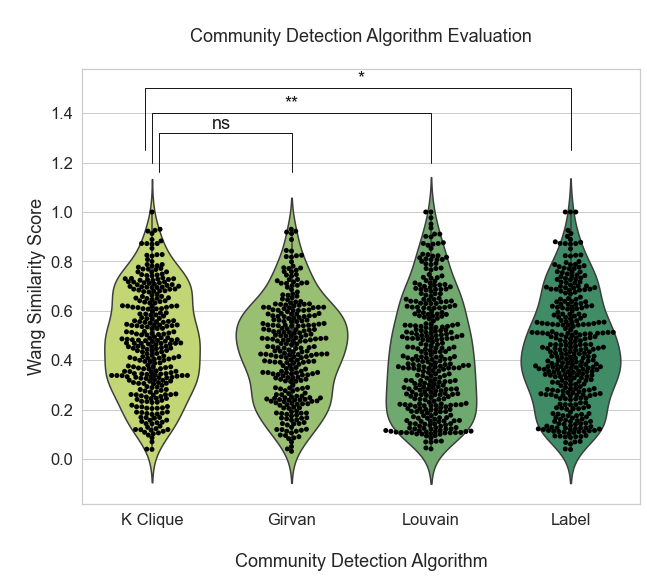

In [23]:
# Plot results
sns.set(rc={'figure.figsize':(10,8)}, style='whitegrid', font_scale=1.5)
ax = sns.violinplot(x="Algorithm", y="value", data=plot_df, palette='summer_r')
ax = sns.swarmplot(x="Algorithm", y="value", data=plot_df, color='black', edgecolor='gray')
ax.set_title('\nCommunity Detection Algorithm Evaluation\n')
ax.set(xlabel='\nCommunity Detection Algorithm', ylabel='\nWang Similarity Score')

# Add statistical annotation
# K-clique and Girvan-Newman (not significant)
x1, x2 = 0, 1
y, h, col = plot_df['value'].max() + 0.16, 0.16, 'k'
plt.plot([x1+0.05, x1+0.05, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

# K-clique and Louvain (highly significant)
x1, x3 = 0, 2
y, h, col = plot_df['value'].max() + 0.2, 0.2, 'k'
plt.plot([x1, x1, x3, x3], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x3)*.5, y+h, "**", ha='center', va='bottom', color=col)

# K-clique and Label Propagation (significant)
x1, x4 = 0, 3
y, h, col = plot_df['value'].max() + 0.25, 0.25, 'k'
plt.plot([x1-0.05, x1-0.05, x4, x4], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x4)*.5, y+h, "*", ha='center', va='bottom', color=col)

sl.save_fig('Community_Detection_Evaluation_swarm', tight_layout=False)
plt.show()

In [15]:
k_vals = plot_df[plot_df['Algorithm'] == 'Label']
mean = k_vals[['value']].mean()
print(f'K-Clique Mean Similarity is: {mean}')

K-Clique Mean Similarity is: value    0.436917
dtype: float64
